<a href="https://colab.research.google.com/github/sssiyam-sudo/MasterThesisWork/blob/main/kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing all the necessary libraries & packages.

In [1]:
import os
import pandas as pd
import numpy as np
from math import sqrt
import seaborn as sns
import missingno as msno
import plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from sklearn import preprocessing , metrics 

In [23]:
df = pd.read_csv('/content/drive/MyDrive/ThesisWork/nsclc_pd1_msk_2018_clinical_data.tsv', sep='\t')

#-----------------
#-----------------
#-----------------

-------------------------------------
## **Data exploration and cleaning.**
-------------------------------------

In [24]:
df.rename(columns = {'Study ID':'Study_ID', 'Patient ID':'Patient_ID',
                     'Sample ID':'Sample_ID' , 'Diagnosis Age':'Diagnosis_Age' ,
                     'Cancer Type':'Cancer_Type' , 'Cancer Type Detailed':'Cancer_Type_Detailed' ,
                     'Durable Clinical Benefit':'Durable_Clinical_Benefit' , 'FGA':'FGA' , 
                     'Fraction Genome Altered':'Fraction_Genome_Altered' , 'Gene Panel':'Gene_Panel',
                     'Lines of treatment':'Lines_of_treatment' , 'Mutation Count':'Mutation_Count' , 
                     'Mutation Rate':'Mutation_Rate' , 'Oncotree Code':'Oncotree_Code', 
                     'PD-L1 Score (%)':'PD-L1Score%' , 'Progress Free Survival (Months)':'ProgressFreeSurvival_Months' ,
                     'Progression Free Status':'ProgressionFreeStatus' ,
                     'Number of Samples Per Patient':'Number_of_Samples_Per_Patient' , 'Sex':'Gender' ,
                     'Smoker':'Smoker' , 'Somatic Status':'Somatic_Status' , 'TMB (nonsynonymous)':'TMB(nonsynonymous)',
                     'Treatment Type':'Treatment_Type'}, inplace = True)

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Study_ID                       240 non-null    object 
 1   Patient_ID                     240 non-null    object 
 2   Sample_ID                      240 non-null    object 
 3   Diagnosis_Age                  240 non-null    int64  
 4   Cancer_Type                    240 non-null    object 
 5   Cancer_Type_Detailed           240 non-null    object 
 6   Durable_Clinical_Benefit       240 non-null    object 
 7   FGA                            240 non-null    float64
 8   Fraction_Genome_Altered        240 non-null    float64
 9   Gene_Panel                     240 non-null    object 
 10  IRB                            240 non-null    object 
 11  Lines_of_treatment             240 non-null    int64  
 12  Mutation_Count                 240 non-null    int

In [25]:
#Finally we will keep only the columns that have the bigger impacts on the target.
df.drop(df.columns[[0,1,2,3,4,5,7,8,9,10,11,14,15,16,17,18,19,20,21,23]], axis=1, inplace=True)

<AxesSubplot:>

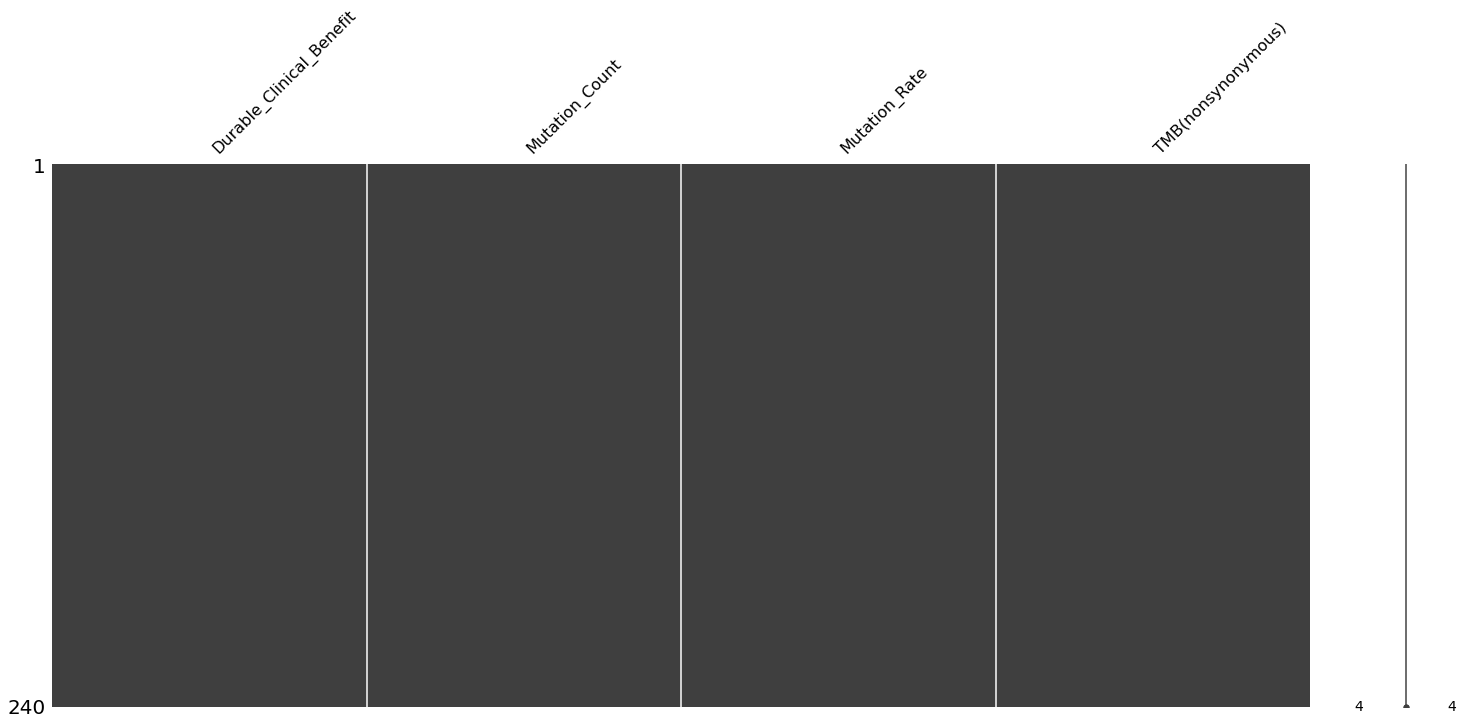

In [7]:
msno.matrix(df)

In [26]:
df.groupby(['Durable_Clinical_Benefit'])['Durable_Clinical_Benefit'].count()

Durable_Clinical_Benefit
NE      13
NO     158
YES     69
Name: Durable_Clinical_Benefit, dtype: int64

#-----------------
#-----------------
#-----------------

In [27]:
df = df.sample(frac=1) #this will randomly shuffle the rows to make sure the data is not sorted.

In [28]:
df.drop(df.index[df['Durable_Clinical_Benefit'] == 'NE'], inplace=True) #removing the NE class from the dataset

In [68]:
df.drop(df.index[df['Mutation_Rate'] > 49], inplace=True)

In [69]:
df.head()

,Durable_Clinical_Benefit,Mutation_Count,Mutation_Rate,TMB(nonsynonymous)
79,0,9,9.183673,9.982398
104,1,6,5.660377,5.872318
160,0,11,10.377358,10.765917
162,1,8,7.547170,7.829758
222,0,11,9.016393,9.511679


#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------

In [70]:
X = df.drop(["Durable_Clinical_Benefit"], axis=1)
y = df["Durable_Clinical_Benefit"] #This will be our target to predict.

In [71]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)

# statistics of scaled data
pd.DataFrame(data_scaled).describe()

,0,1,2
count,2.250000e+02,2.250000e+02,2.250000e+02
mean,7.105427e-17,-1.973730e-16,-2.368476e-17
std,1.002230e+00,1.002230e+00,1.002230e+00
min,-1.067317e+00,-1.087883e+00,-1.091858e+00
25%,-7.012405e-01,-7.085503e-01,-7.123540e-01
50%,-2.131381e-01,-2.458045e-01,-2.311705e-01
75%,2.749644e-01,2.606341e-01,3.185714e-01
max,4.789912e+00,4.985408e+00,4.767413e+00


In [72]:
data_scaled = pd.get_dummies(X) #One Hot Encoding 
# initializing sklearn labelencoder
label_encoder = preprocessing.LabelEncoder()
cols = ['Durable_Clinical_Benefit']
# sklearn labelencoder
df[cols] = df[cols].apply(preprocessing.LabelEncoder().fit_transform)
y = df["Durable_Clinical_Benefit"]

In [73]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [74]:
data = data_scaled

## Applying elbow method for selecting K value

In [75]:
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(data)
    inertia.append(algorithm.inertia_)


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1373: RuntimeWarning:

algorithm='elkan' doesn't make sense for a single cluster. Using 'lloyd' instead.



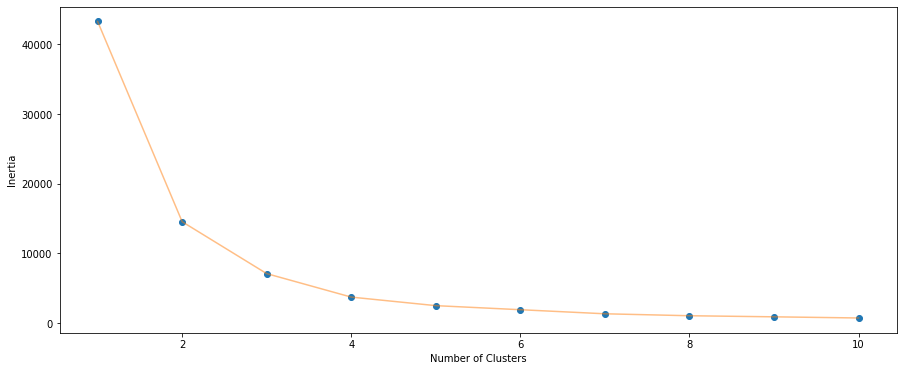

In [76]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

## Fitting the K means with selected K value

In [77]:
algorithm = (KMeans(n_clusters = 2 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(data)
labels3 = algorithm.labels_
centroids3 = algorithm.cluster_centers_

In [85]:
data['label3'] =  labels3
trace1 = go.Scatter3d(
    x= data['Mutation_Count'],
    y= data['Mutation_Rate'],
    z= data['TMB(nonsynonymous)'],
    mode='markers',
     marker=dict(
        color = data['label3'], 
        size= 10,
        line=dict(
            color= data['label3'],
            width= 5
        ),
        opacity=.9
     )
)

dt = [trace1]
layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     )
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'Mutation_Count'),
            yaxis = dict(title  = 'Mutation_Rate'),
            zaxis = dict(title  = 'TMB')
        )
)
fig = go.Figure(data=dt, layout=layout)
py.offline.iplot(fig)